In [1]:
% temperature dependent properties
% 1D radial geometry, two-material configuration
% non-linear conduction equation
% multiply by dr^2
% with transient heat source q(t) and R_thermal(T)
clear;
close all;

## geometry

In [2]:
ro_heater = 4.25*10^-3; % [m]
ro_zro2 = 30.70*10^-3; % [m] instead of 30.734 mm
dr = 0.05*10^-3; % [m] grid size: can be greater than greatest common divisor of two lengths

r_grid_heater = linspace(0, ro_heater, 1+ro_heater/dr)'; % including interface
r_grid_zro2 = linspace(ro_heater, ro_zro2, 1+(ro_zro2-ro_heater)/dr)'; % including interface
r_grid_total = linspace(0, ro_zro2, 1+ro_zro2/dr)';
N_grid_heater = length(r_grid_heater);
N_grid_total = length(r_grid_total);

H_heater = 0.1; % [m] height

## heat source magnitude and outer temperature

In [3]:
Q_heater = 1000; % [W] total heat rate
q_heater = Q_heater/H_heater/(pi*ro_heater^2); % [W/m3] volumetric heat rate
T_outer = 500 + 273.15; % [K] boundary condition

## time step

In [4]:
time_end = 100; % [s] INPUT last time
dt = 1; % [s] INPUT time step
time_grid = linspace(0, time_end, 1+time_end/dt)';
N_time = length(time_grid);
T_transient = zeros(N_grid_total, N_time);
q_transient = zeros(N_time, 1);

## case) heat source transient: pulse

In [5]:
% case) heat source transient: constant
% q_transient = ones(N_time,1)*q_heater; % constant

% case) heat source transient: linear
% q_transient = linspace(0, q_heater*3, N_time)'; % linear1

number_pulse = 3; % INPUT
% Calculate pulse duration based on the number of pulses
pulse_duration = time_end / (2 * number_pulse - 1);  % Duration for each on/off segment
% Loop to define each pulse on/off segment
for it = 1:number_pulse
    % Calculate the start and end time of each "on" pulse
    on_start = (2 * it - 2) * pulse_duration;
    on_end = on_start + pulse_duration;
    % Set power to "on" during each pulse
    q_transient(time_grid >= on_start & time_grid < on_end) = q_heater*3;
end

## matrix: discretization, thermal properties

In [6]:
A = sparse(N_grid_total, N_grid_total); % new time step
B = sparse(N_grid_total, N_grid_total); % prev time step
C = sparse(N_grid_total, 1); % source term

k_i = zeros(N_grid_total, N_time+1); % thermal conductivity at node i
rhocp_i = zeros(N_grid_total, N_time+1); % rho*c_p at node i
k_i_face = zeros(N_grid_total-1, N_time+1); % correspond to i+1/2 location
R_transient = zeros(N_time,1); % to be stored

## initialization (t=0)

In [7]:
fprintf('initialization (time: %d second) \n', time_grid(1));

initialization (time: 0 second)

In [8]:
T_transient(:,1) = T_outer; % initial condition
R_transient(1) = Rgap_T(T_outer);

idx = 1:N_grid_heater-1; % heater
k_i(idx,1) = k_T_heater(T_outer); % use kelvin for input temperature
rhocp_i(idx,1) = rhocp_T_heater(T_outer);

idx = N_grid_heater; % gap
k_i(idx,1) = 1/(0.5/k_T_heater(T_outer) + 0.5/k_T_zro2(T_outer) + R_transient(1)/dr);
rhocp_i(idx,1) = 0.5*(rhocp_T_heater(T_outer) + rhocp_T_zro2(T_outer));

idx = N_grid_heater+1:N_grid_total; % zro2
k_i(idx,1) = k_T_zro2(T_outer);
rhocp_i(idx,1) = rhocp_T_zro2(T_outer);

k_i_face(:,1) = 1./(0.5./k_i(1:end-1,1) + 0.5./k_i(2:end,1)); % i+1/2 location
% face #1: (1,2), face #2: (2,3), face #(N_grid_total-1):(N_grid_total-1, N_grid_total)

% prepare for next time step
k_i(:,2) = k_i(:,1);
rhocp_i(:,2) = rhocp_i(:,1);
k_i_face(:,2) = k_i_face(:,1);

## solve matrix equation (t>0)

In [9]:
for it=2:N_time
    fprintf('time: %d second \n', time_grid(it));

time: 1 second 
time: 2 second 
time: 3 second 
time: 4 second 
time: 5 second 
time: 6 second 
time: 7 second 
time: 8 second 
time: 9 second 
time: 10 second 
time: 11 second 
time: 12 second 
time: 13 second 
time: 14 second 
time: 15 second 
time: 16 second 
time: 17 second 
time: 18 second 
time: 19 second 
time: 20 second 
time: 21 second 
time: 22 second 
time: 23 second 
time: 24 second 
time: 25 second 
time: 26 second 
time: 27 second 
time: 28 second 
time: 29 second 
time: 30 second 
time: 31 second 
time: 32 second 
time: 33 second 
time: 34 second 
time: 35 second 
time: 36 second 
time: 37 second 
time: 38 second 
time: 39 second 
time: 40 second 
time: 41 second 
time: 42 second 
time: 43 second 
time: 44 second 
time: 45 second 
time: 46 second 
time: 47 second 
time: 48 second 
time: 49 second 
time: 50 second 
time: 51 second 
time: 52 second 
time: 53 second 
time: 54 second 
time: 55 second 
time: 56 second 
time: 57 second 
time: 58 second 
time: 59 second 
time: 

## discretization

In [10]:
    % center symmetry line
    idx = 1;
    A(idx, idx) = 4*k_i_face(idx,it) + rhocp_i(idx,it)/dt*dr^2;
    A(idx, idx+1) = -4*k_i_face(idx,it);
    B(idx, idx) = rhocp_i(idx,it)/dt*dr^2;
    C(idx) = q_transient(it)*dr^2;

    % intermediate
    idx = 2:(N_grid_total - 1);
    vector_idx = idx + (idx - 1)*N_grid_total;
    A(vector_idx) = (k_i_face(idx,it)+k_i_face(idx-1,it)) + (k_i_face(idx,it)-k_i_face(idx-1,it))/2./r_grid_total(idx)*dr + rhocp_i(idx,it)/dt*dr^2; % [i, i]
    A(vector_idx+N_grid_total) = -k_i_face(idx,it) - k_i_face(idx,it)/2./r_grid_total(idx)*dr; % [i, i+1]
    A(vector_idx-N_grid_total) = -k_i_face(idx-1,it) + k_i_face(idx-1,it)/2./r_grid_total(idx)*dr; % [i, i-1]
    B(vector_idx) = rhocp_i(idx,it)/dt*dr^2;

    idx = 2:N_grid_heater-1; % heat source from heater (excluding gap)
    C(idx) = q_transient(it)*dr^2;

    C(N_grid_heater) = 1/2*q_transient(it)*dr^2; % gap regime

    % outer boundary
    idx = N_grid_total;
    A(idx, idx) = 1;
    C(idx) = T_outer;

    T_transient(:,it) = A\(B*T_transient(:,it-1) + C);

## properties for next time step (use one from previous time step)

In [11]:
    idx = 1:N_grid_heater-1; % heater
    k_i(idx,it+1) = k_T_heater(T_transient(idx,it)); % use kelvin for input temperature
    rhocp_i(idx,it+1) = rhocp_T_heater(T_transient(idx,it));

    idx = N_grid_heater; % gap
    R_transient(it) = Rgap_T(T_transient(idx,it));
    k_i(idx,it+1) = 1/(0.5/k_T_heater(T_transient(idx,it)) + 0.5/k_T_zro2(T_transient(idx,it)) + R_transient(it)/dr);
    rhocp_i(idx,it+1) = 0.5*(rhocp_T_heater(T_transient(idx,it)) + rhocp_T_zro2(T_transient(idx,it)));

    idx = N_grid_heater+1:N_grid_total; % zro2
    k_i(idx,it+1) = k_T_zro2(T_transient(idx,it));  % use kelvin for input temperature
    rhocp_i(idx,it+1) = rhocp_T_zro2(T_transient(idx,it));

    k_i_face(:,it+1) = 1./(0.5./k_i(1:end-1,it+1) + 0.5./k_i(2:end,it+1));
end

## plot result

In [12]:
time_transient_plot = [0, 10, 20, 50, 100]; % INPUT to be matched with time grid
idx_transient_plot = zeros(length(time_transient_plot),1);

fprintf('grid size [m] %.2e\n', dr)

grid size [m] 5.00e-05

In [13]:
figure;
set(gcf, 'WindowState', 'maximized');
fontsize = 14;

## heat source input


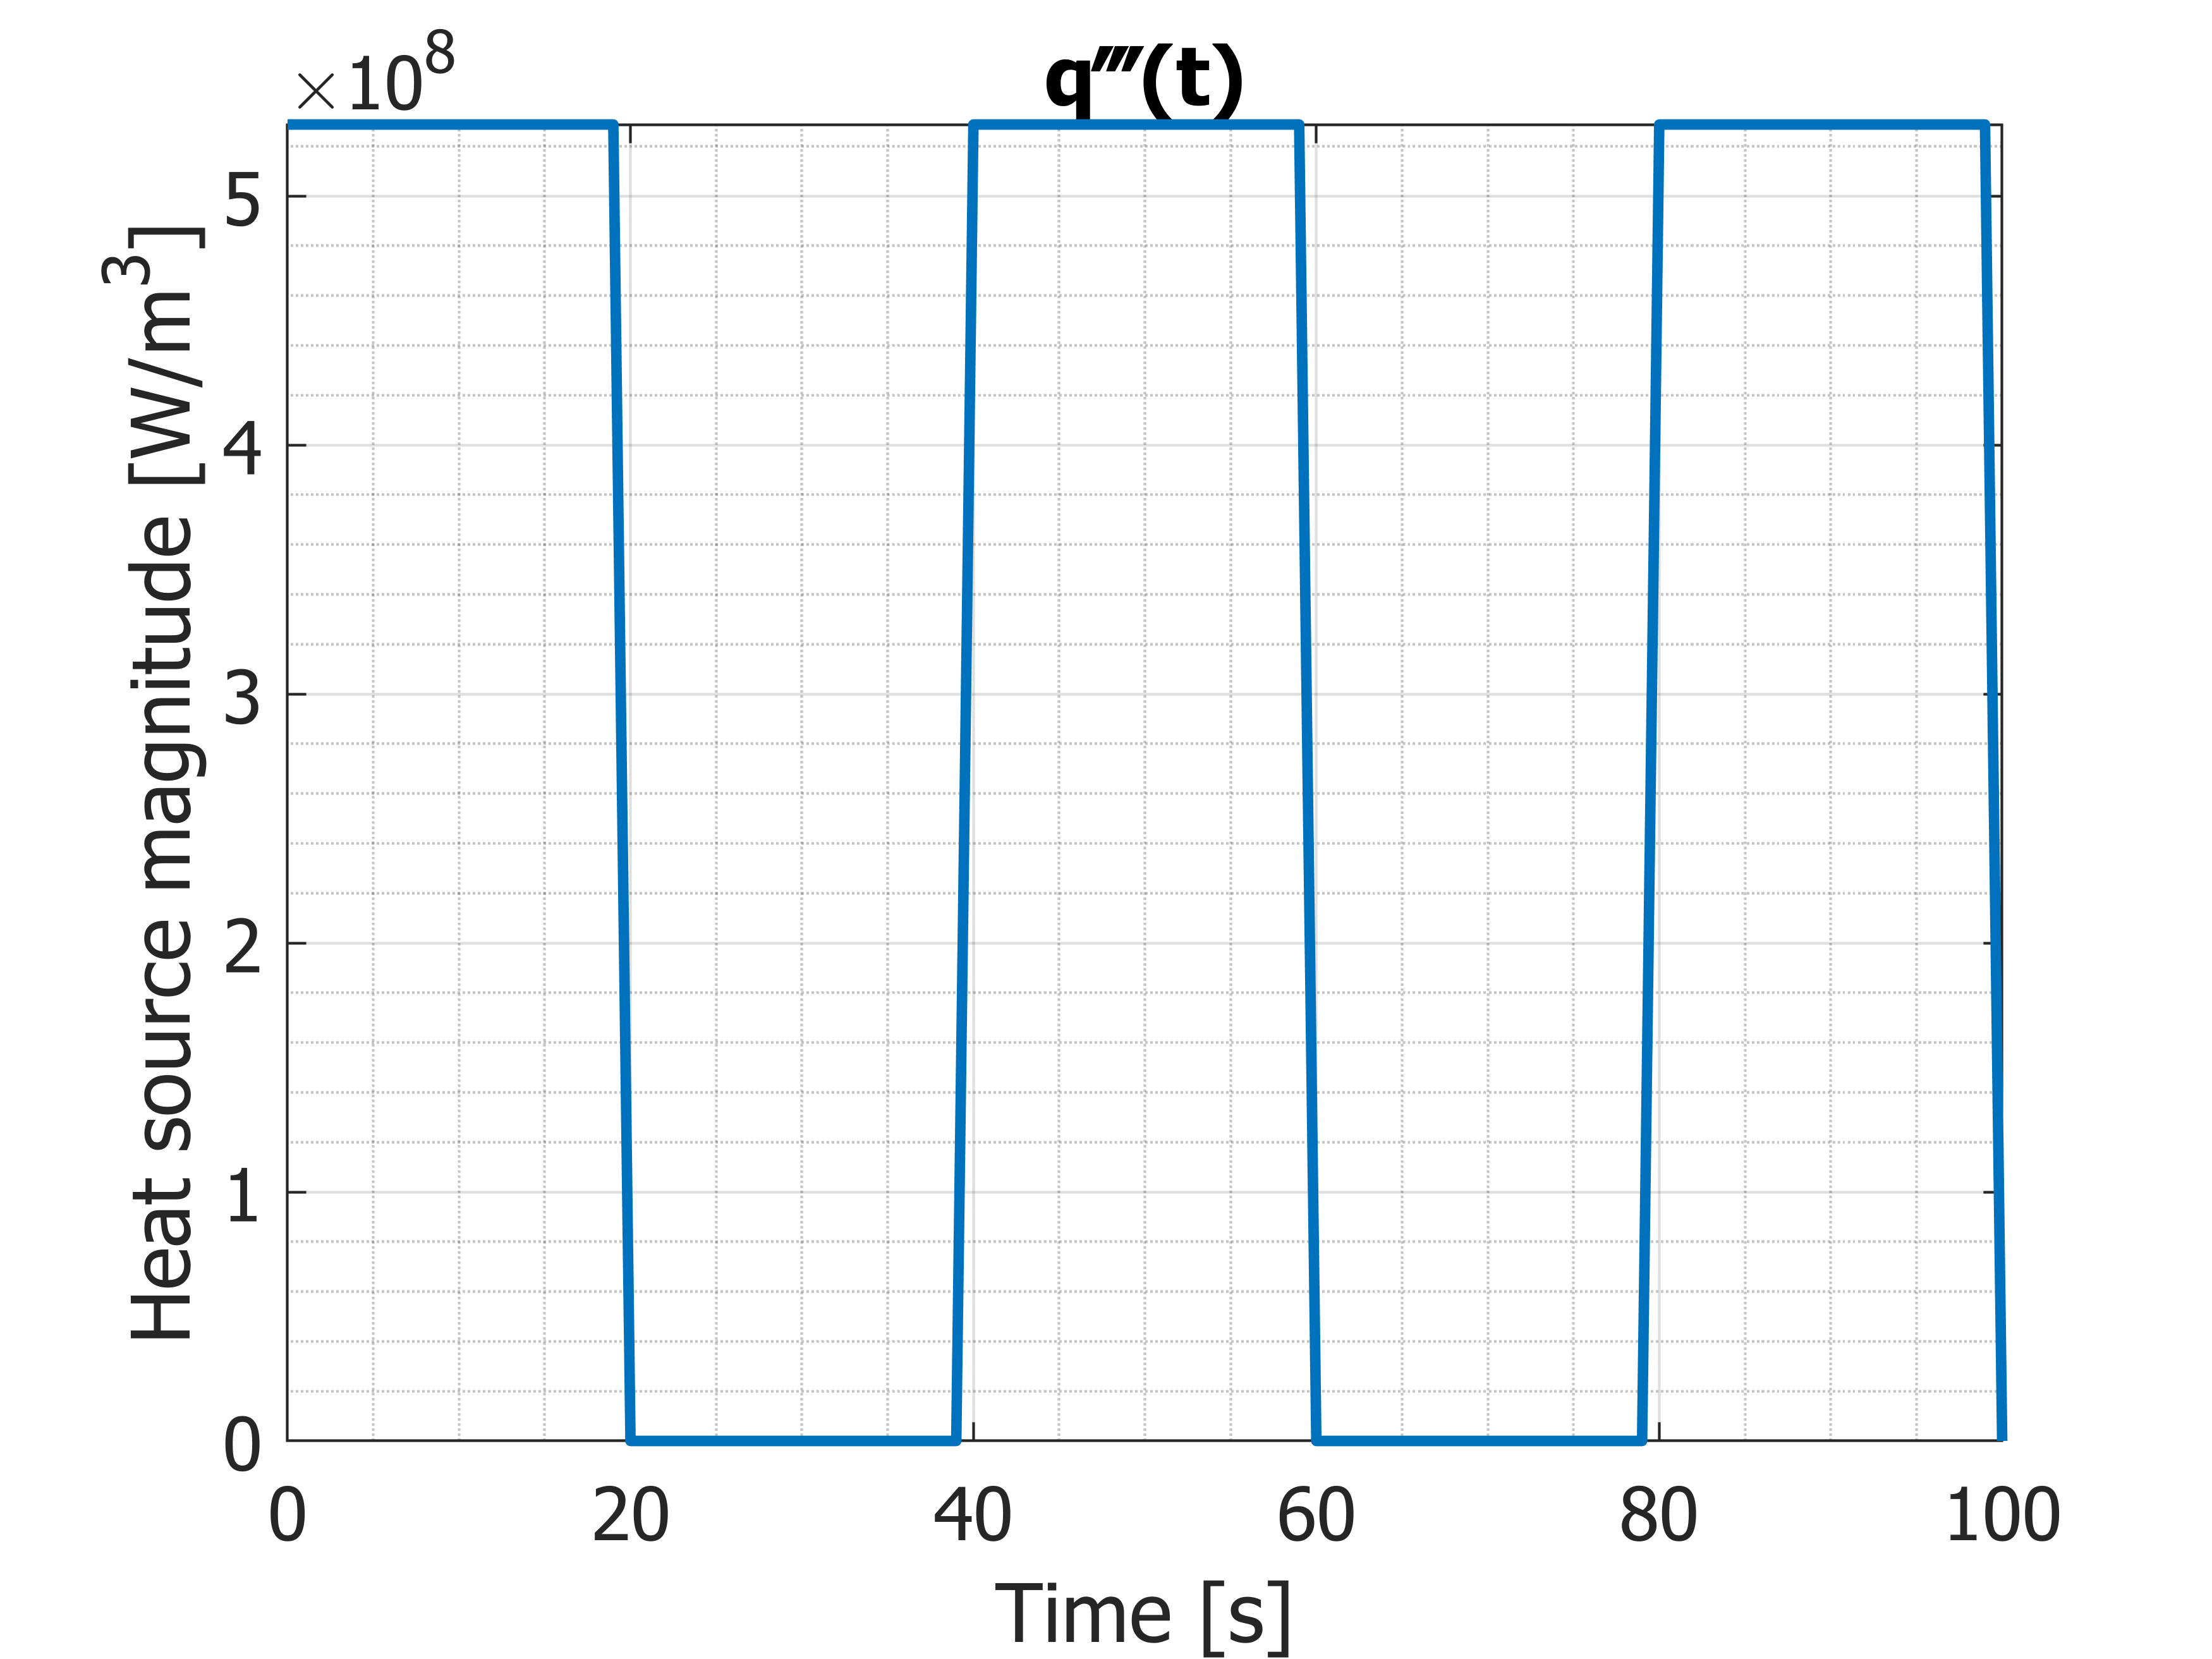

In [14]:
% subplot(2,2,1)
plot(time_grid, q_transient,'Linewidth', 2)
xlabel('Time [s]')
ylabel('Heat source magnitude [W/m^3]')
title("q‴(t)")
grid on
grid minor
ylim([0 inf])
set(gca,'FontSize',fontsize,'fontname','times')

## 1D temperature profile at selected time step

In [15]:
figure;
set(gcf, 'WindowState', 'maximized');
for idx=1:length(time_transient_plot)
    idx_transient_plot(idx) = find(time_grid == time_transient_plot(idx));
    plot(1000*r_grid_total', T_transient(:,idx_transient_plot(idx)) - 273.15,'Linewidth', 2,'displayname',strcat(' t =  ', num2str(time_transient_plot(idx)),' s'))
    hold on
    fprintf('peak temperature [C] (t=%d s) = %.2f \n', time_transient_plot(idx), T_transient(1, idx_transient_plot(idx)) - 273.15);
end

peak temperature [C] (t=0 s) = 500.00 
peak temperature [C] (t=10 s) = 1288.65 
peak temperature [C] (t=20 s) = 1578.90 
peak temperature [C] (t=50 s) = 1666.94 
peak temperature [C] (t=100 s) = 1975.58


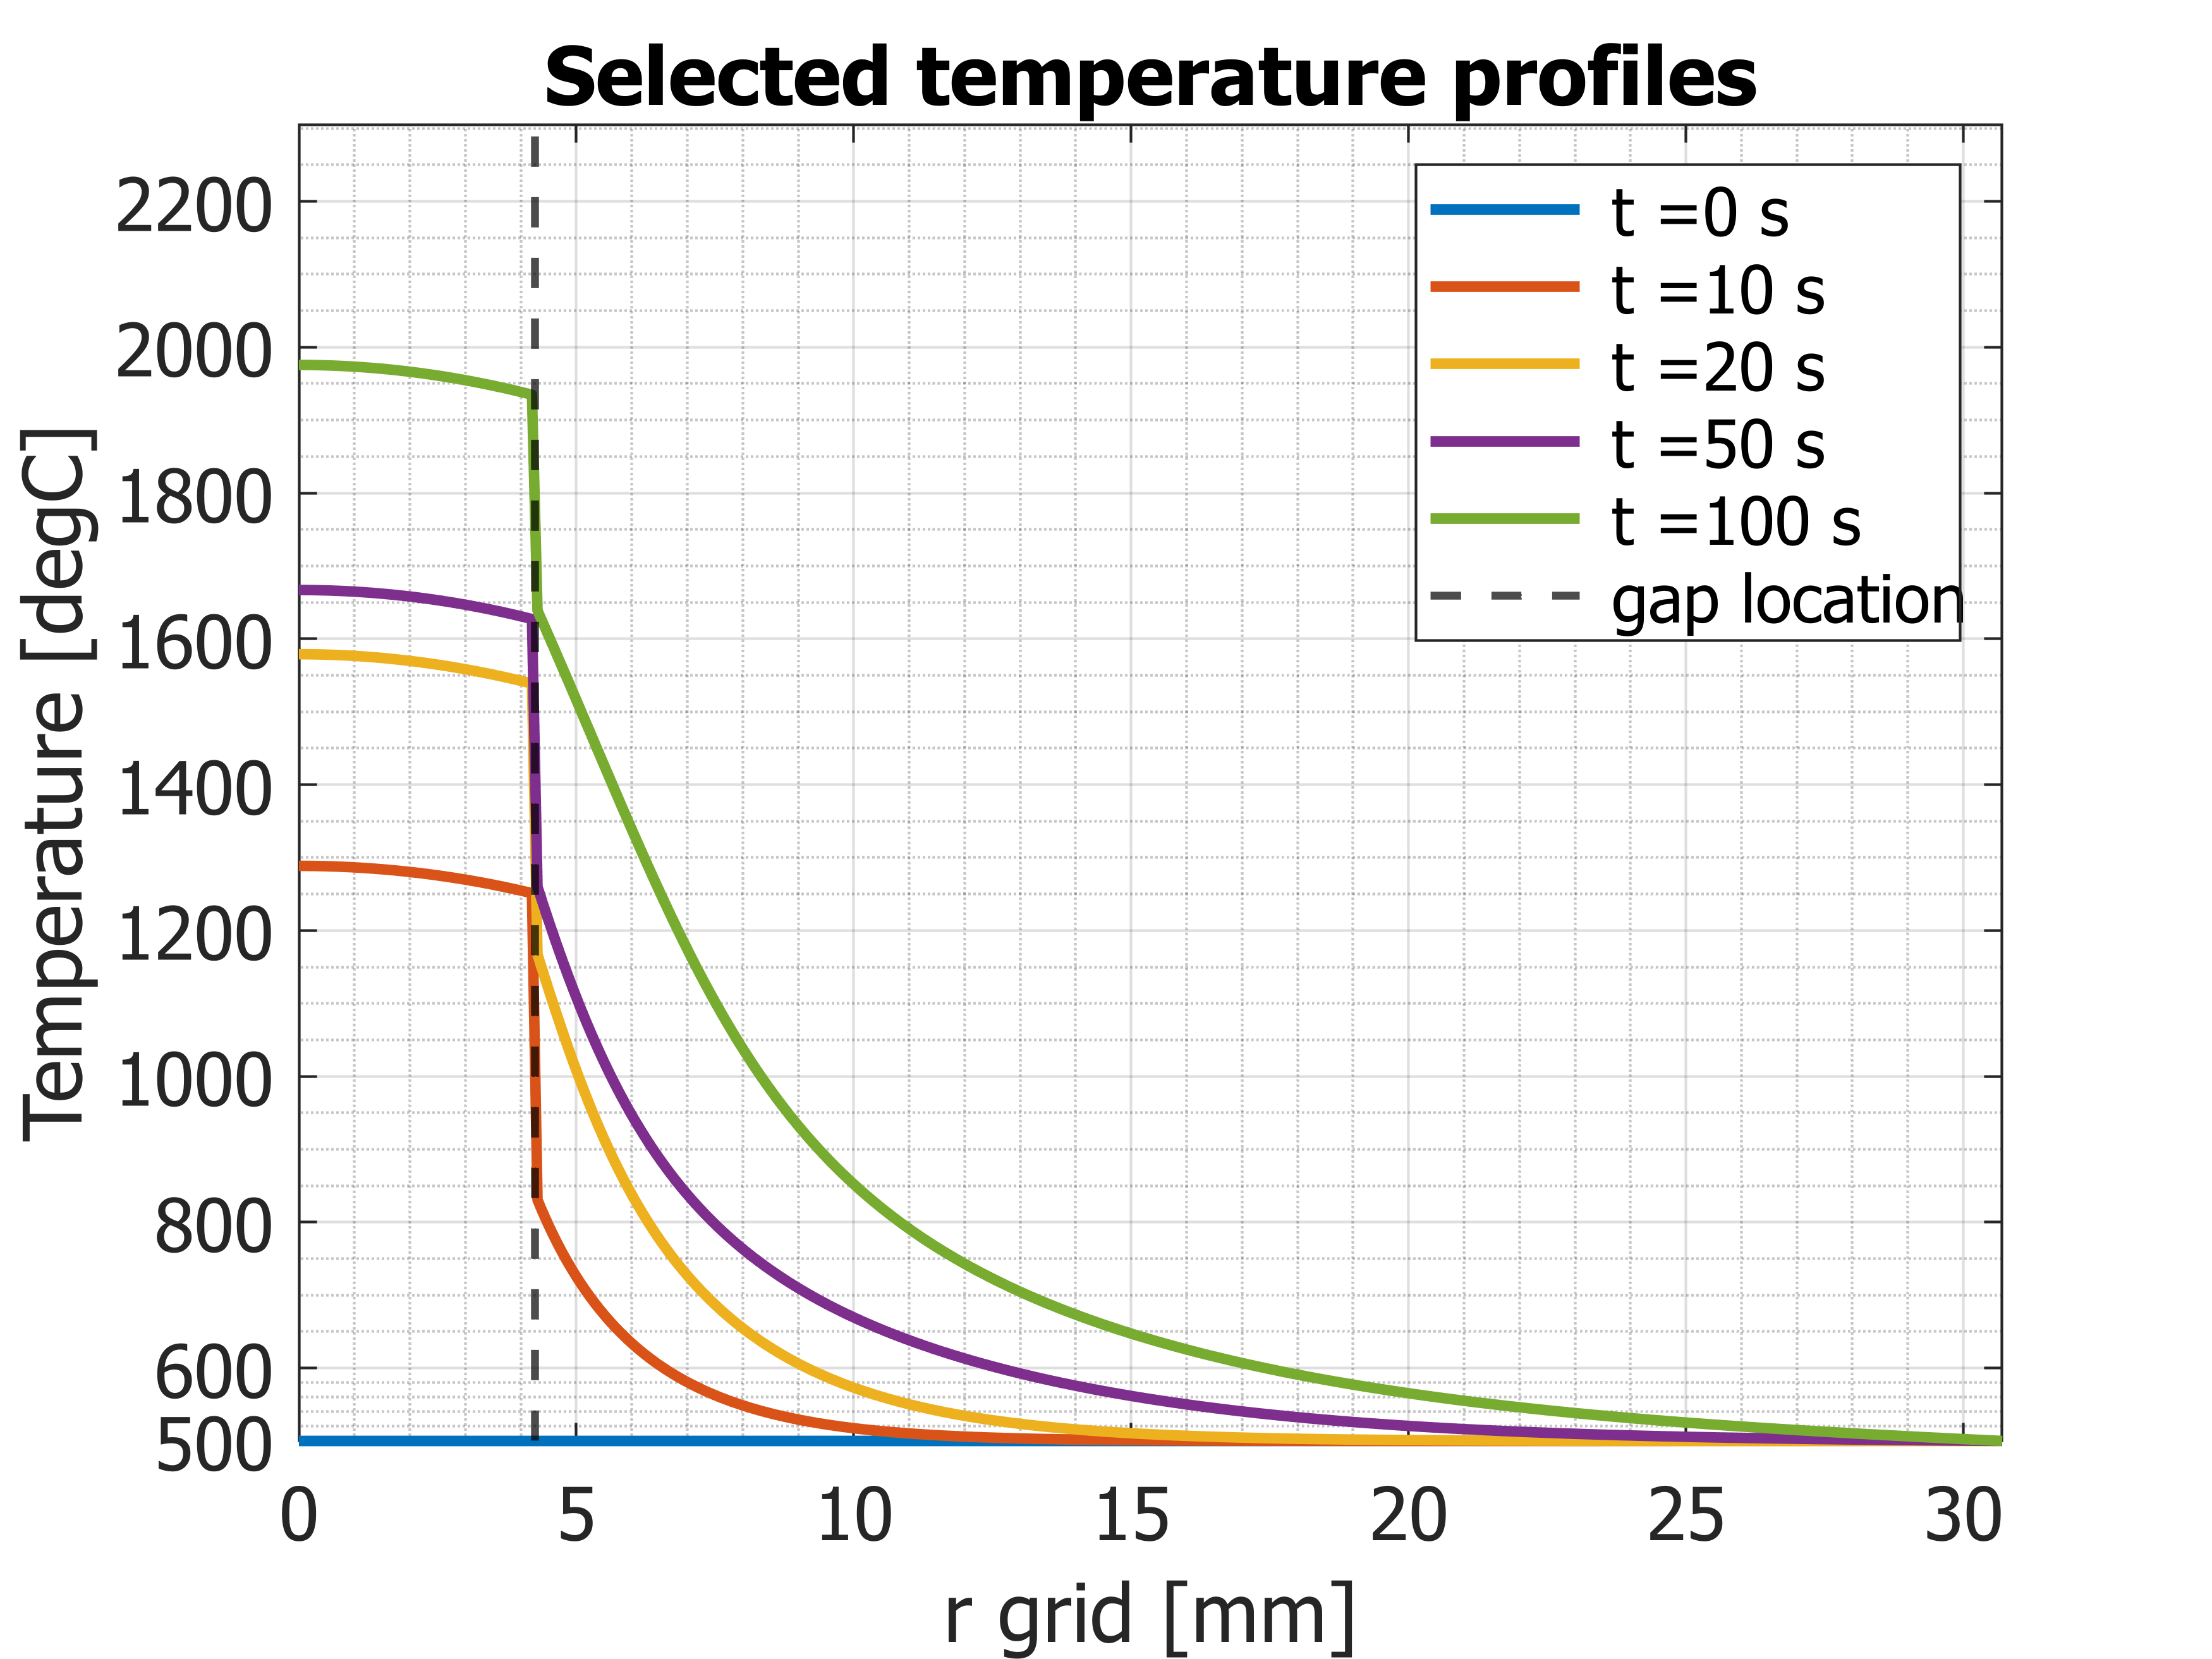

In [16]:
hold on
xline(1000*r_grid_heater(N_grid_heater),'--k','Linewidth',1.5,'displayname',' gap location')
% plot(1000*r_grid_total', T_steady_analytical,'--k','Linewidth',2,'displayname',' steady (analytical)')
legend('show')
xlabel('r grid [mm]')
ylabel('Temperature [degC]')
title("Selected temperature profiles")
set(gca,'FontSize',fontsize,'fontname','times')
xlim([0 ro_zro2*1000])
ylim([500 max(T_transient, [], "all")])
yticks = get(gca, 'YTick'); % Get current y-ticks
yticks = unique([yticks, 500]); % Add 500 and remove duplicates
set(gca, 'YTick', yticks); % Set the modified y-ticks
grid on
grid minor

## gap thermal resistance history


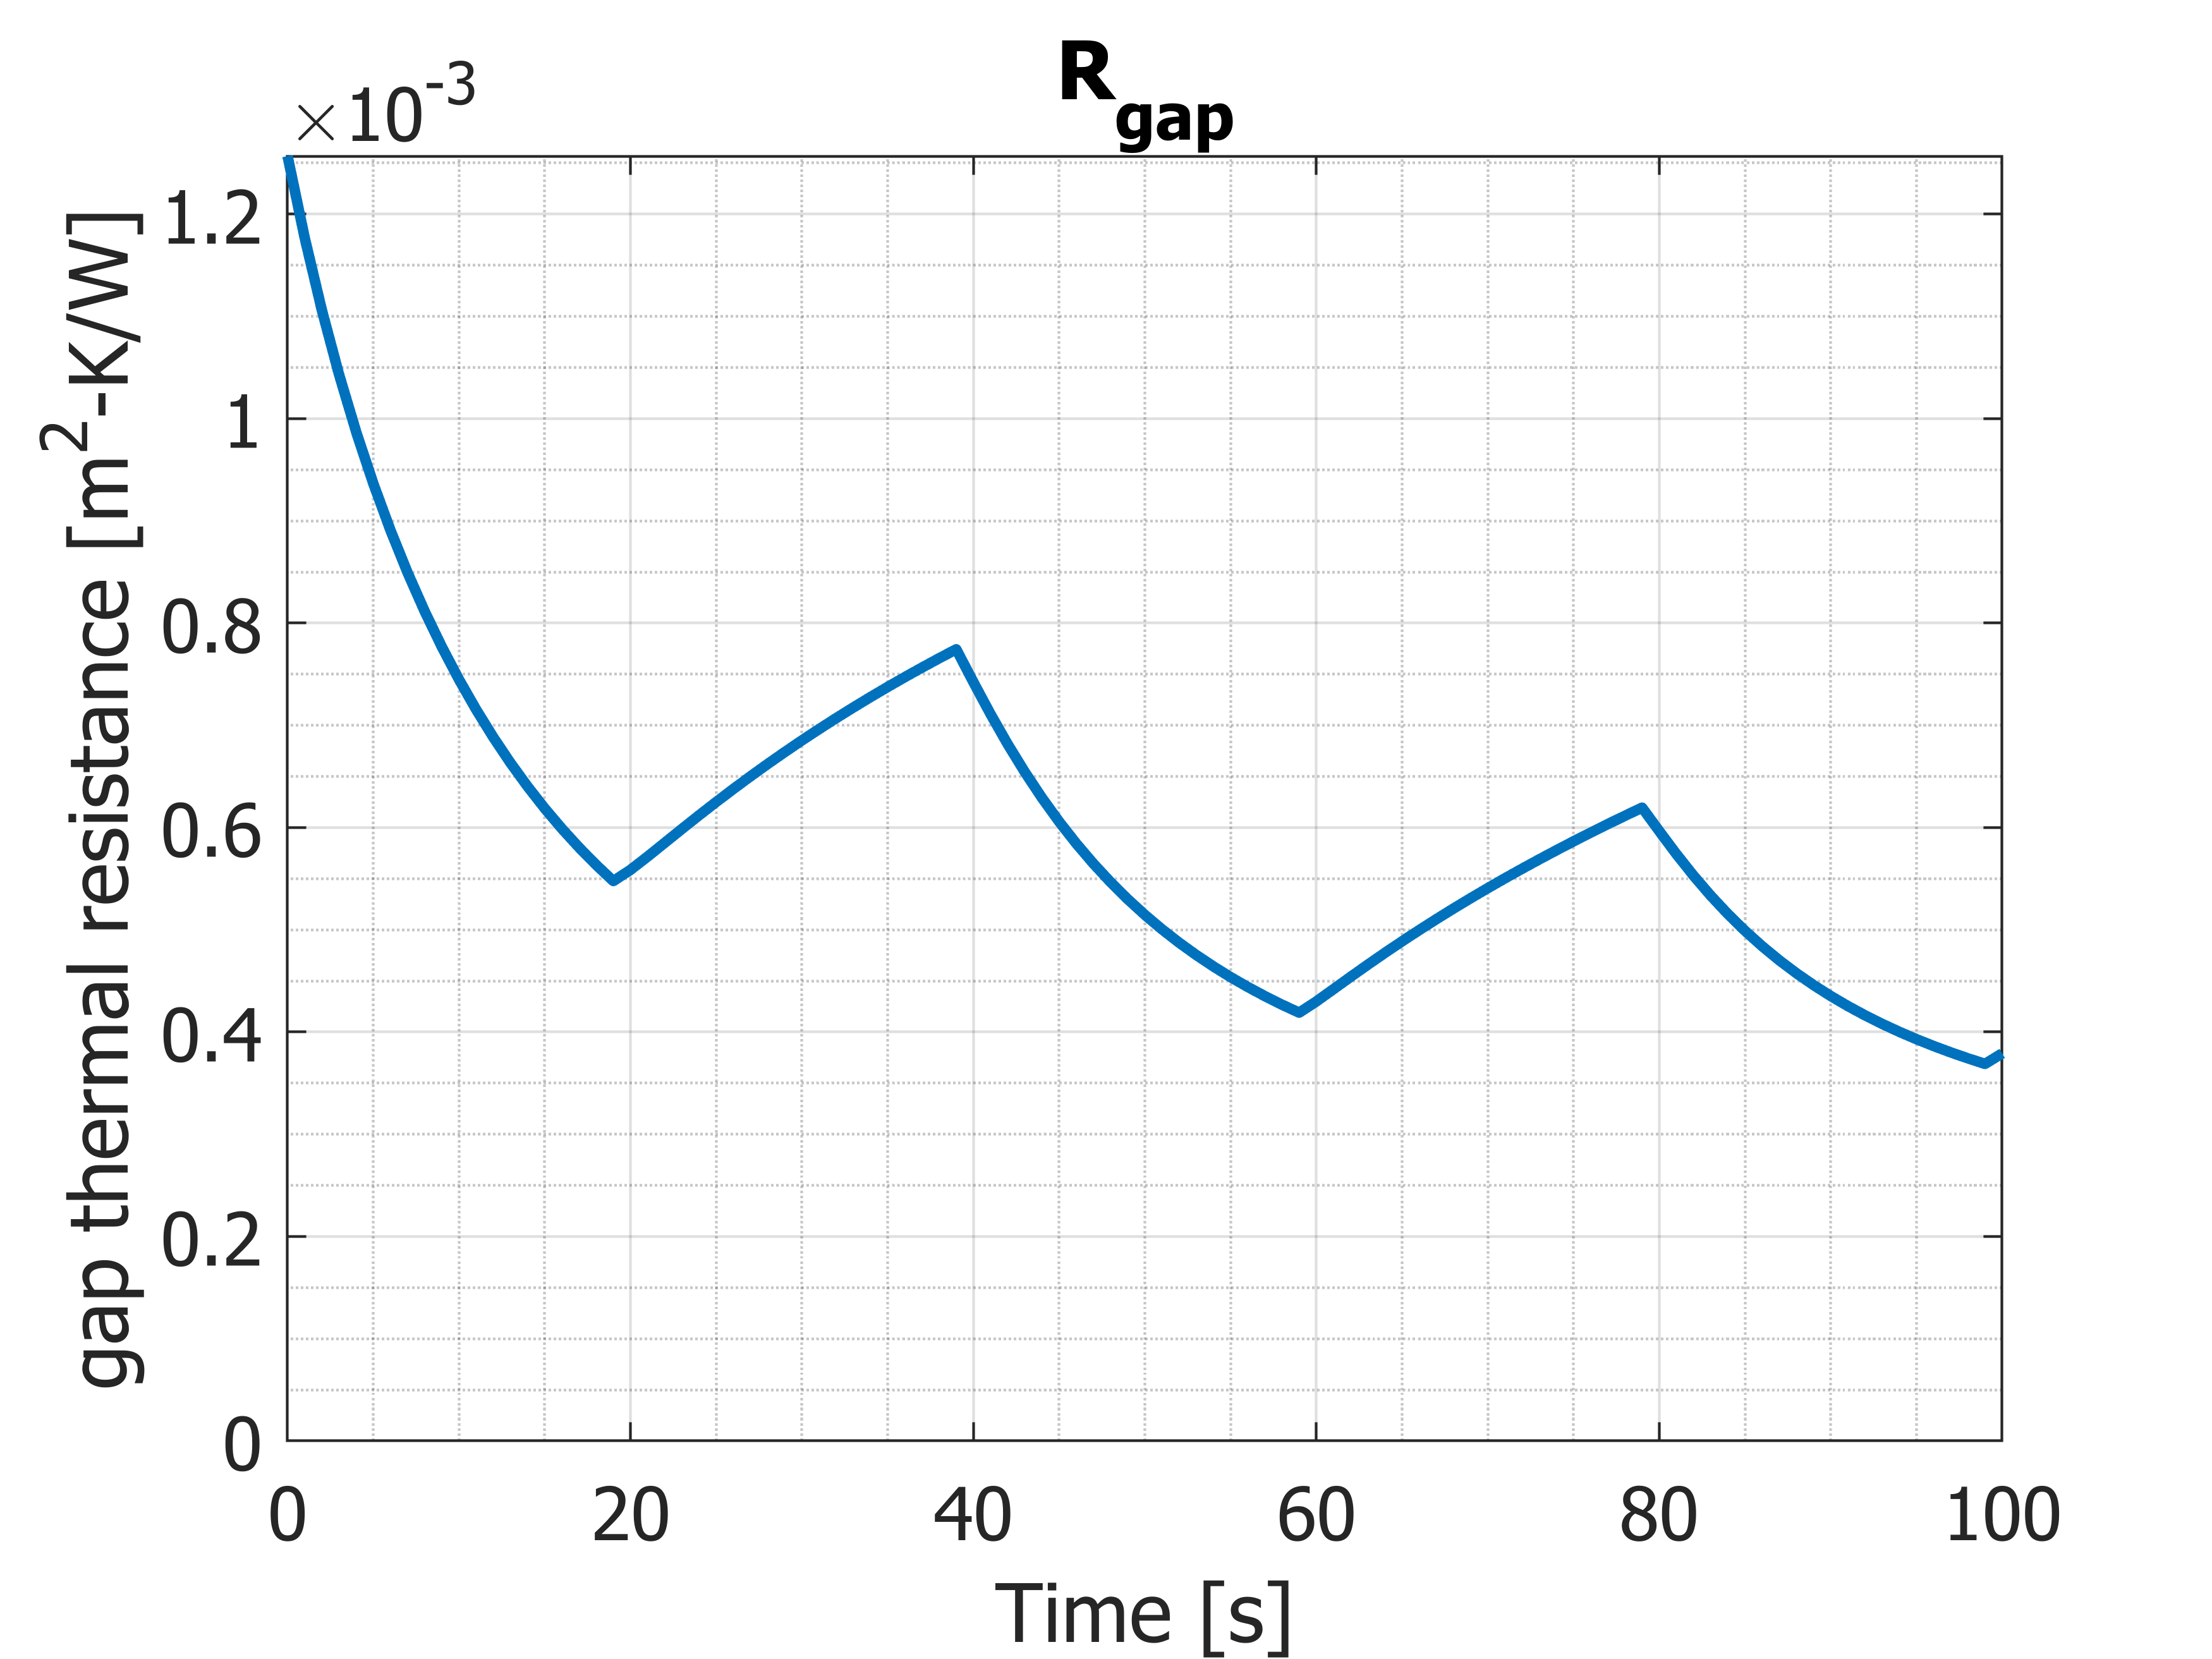

In [17]:
figure;
set(gcf, 'WindowState', 'maximized');
plot(time_grid, R_transient,'Linewidth', 2)
xlabel('Time [s]')
ylabel('gap thermal resistance [m^2-K/W]')
title("R_{gap}")
grid on
grid minor
ylim([0 max(R_transient)])
set(gca,'FontSize',fontsize,'fontname','times')

## colormap temperature history


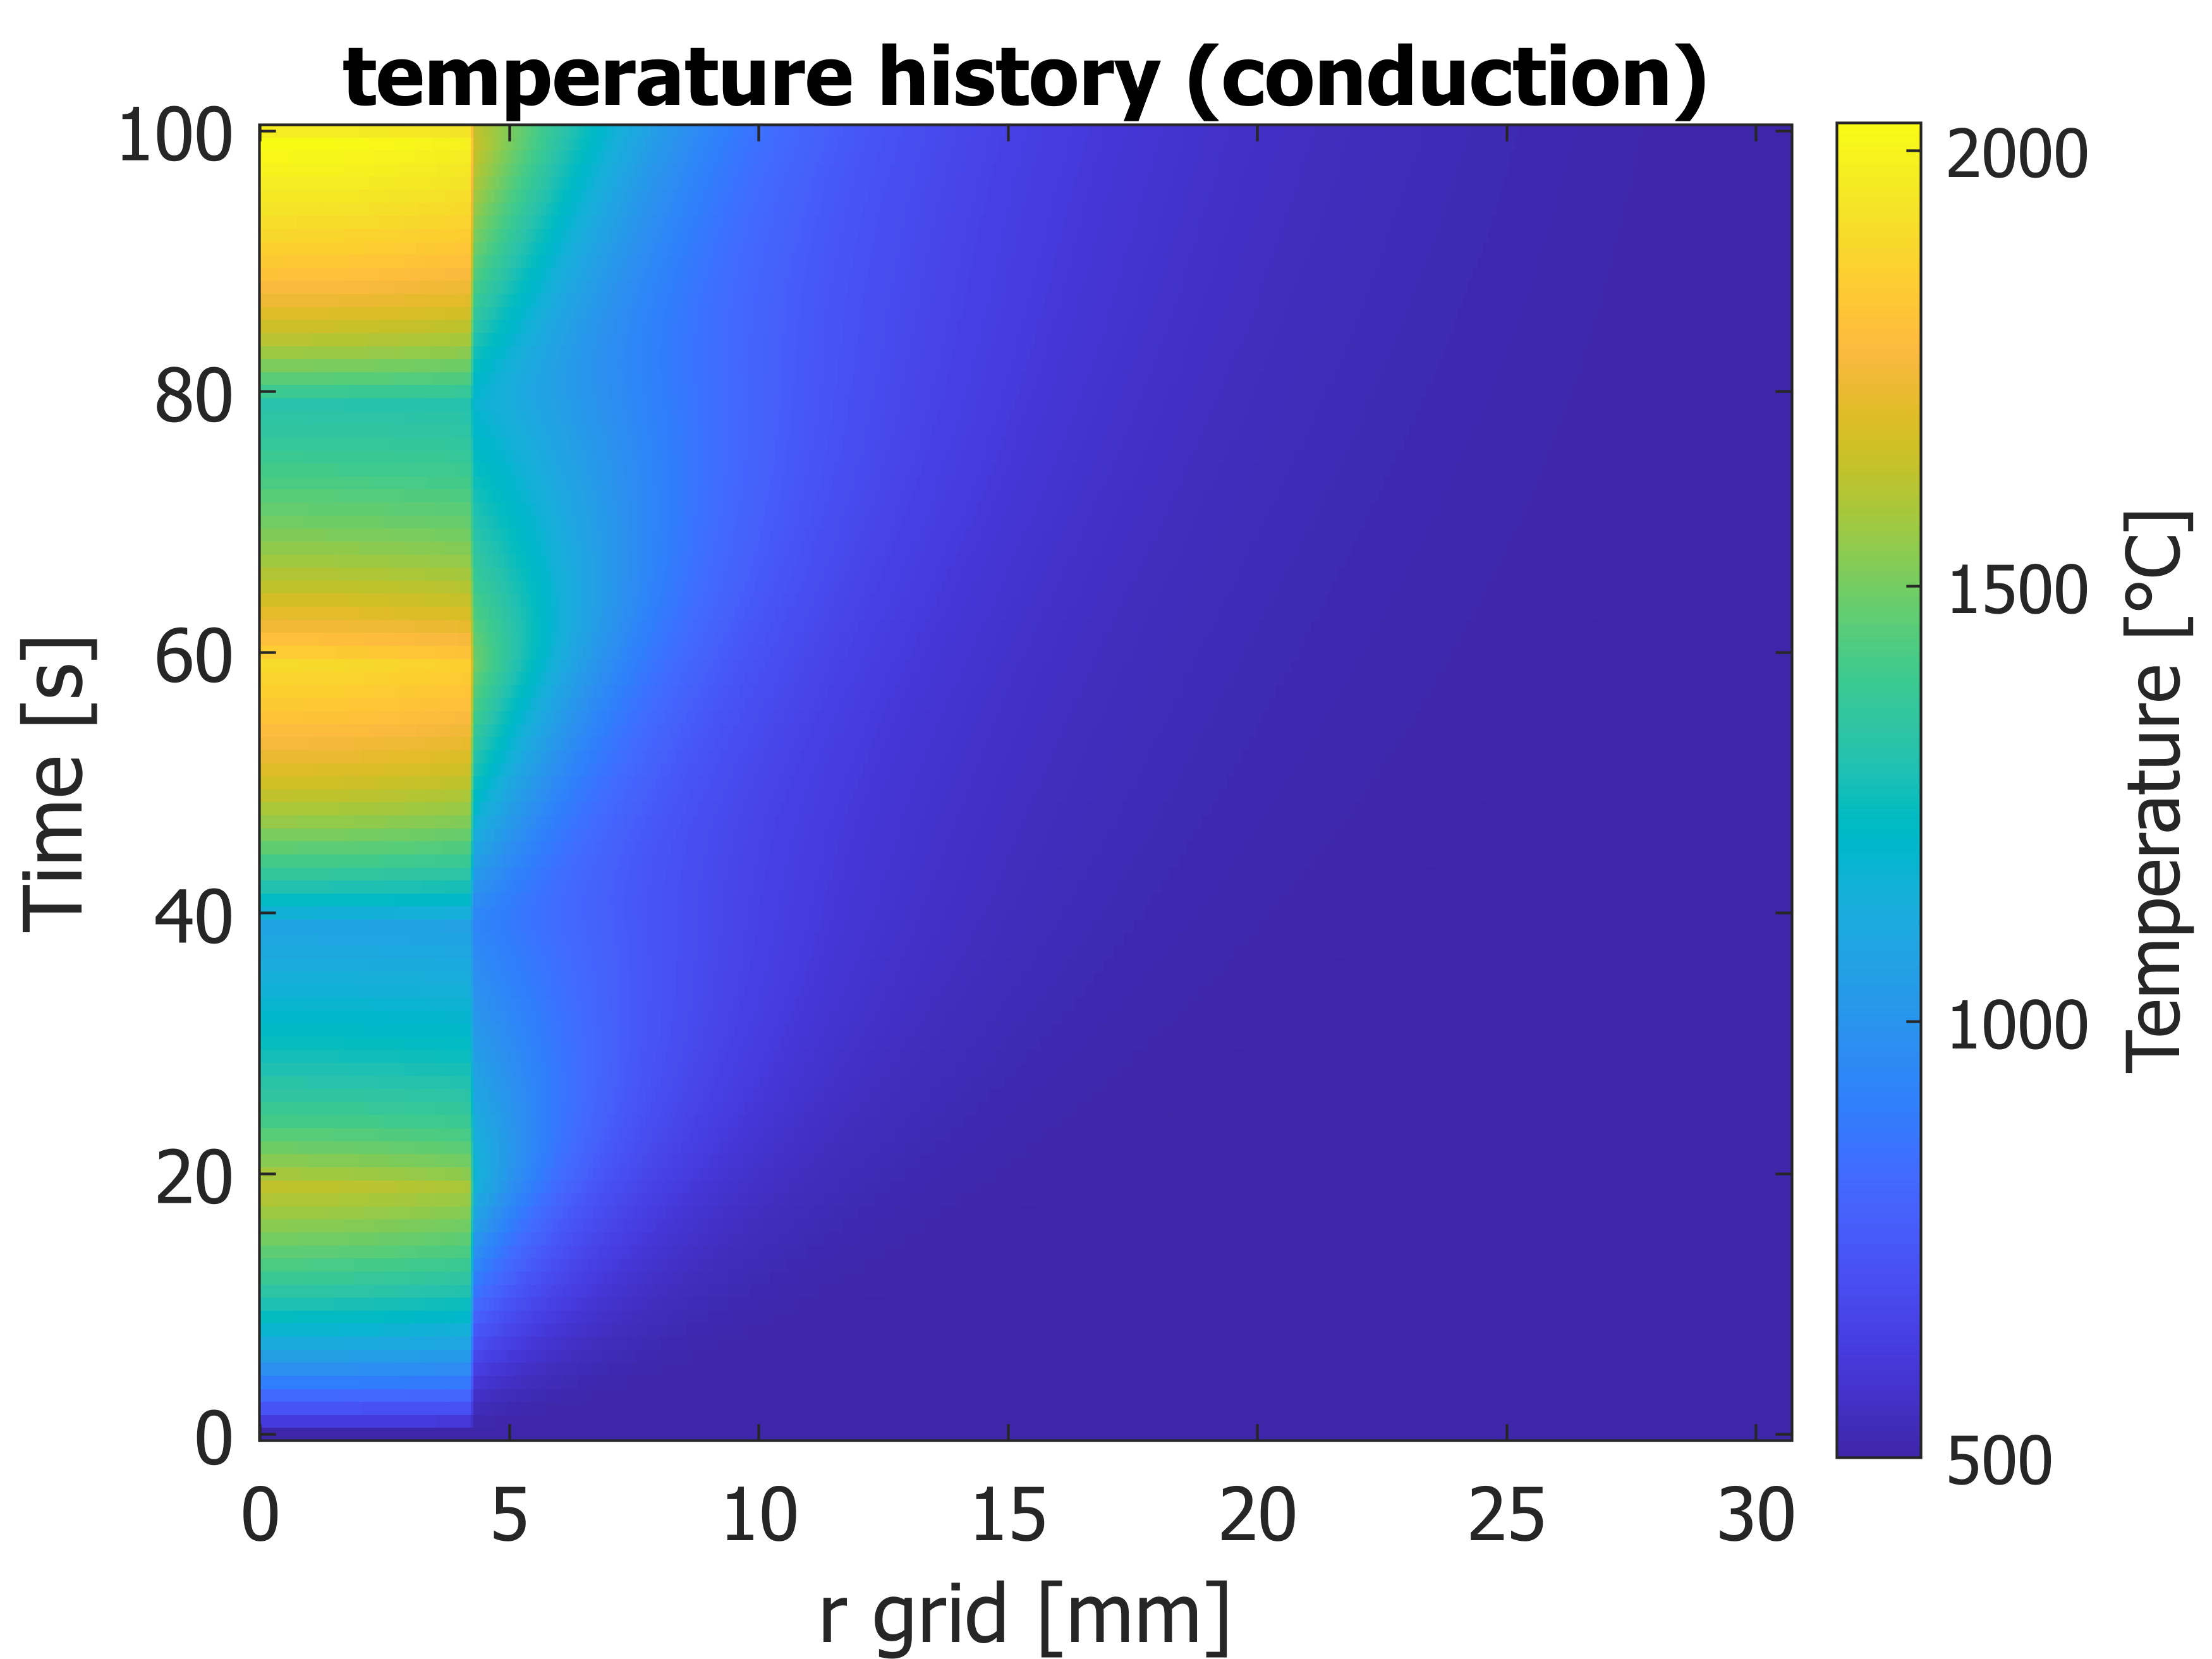

In [18]:
figure;
set(gcf, 'WindowState', 'maximized');
imagesc(1000*r_grid_total, time_grid, T_transient' - 273.15)
set(gca,'YDir','normal')
xlabel('r grid [mm]')
ylabel('Time [s]') % Adjust ylabel appropriately
title('temperature history (conduction)')
c = colorbar; % Create a colorbar
ylabel(c, 'Temperature [°C]','FontSize', fontsize, 'FontName', 'Times') % Set the title for the colorbar
set(gca, 'FontSize', fontsize, 'FontName', 'Times')